In [49]:
import sys, os, time
import numpy as np
import pandas as pd
import pickle

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from estimators.statistical_descriptor import Nagler_WS
# from plot.figure_roc import ROC_plot
from utils.dataset_management import load_train, load_test, parser_pipeline, BFold
from utils.dataset_load import  save_h5_II, load_data_h5, load_info_h5, shuffle_data, Dataset_loader
from utils.fold_management import fold_management
from utils.label_management import label_management
from utils.files_management import (
    load_yaml,
    dump_pkl,
    init_logger,
    open_param_set_dir,
    report_prediction,
    report_metric_from_log,
    write_report
)


In [118]:
with open('../results/study_050624_10H33M37_crocus_mFold/metrics_tmp.pkl', 'rb') as f:
    data = pickle.load(f)


In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import os

def create_plots(metrics_dict, save_dir="plots"):
    """
    Create boxplots and ROC curves from the metrics dictionary and save them as individual files.

    Parameters
    ----------
    metrics_dict : dict
        Dictionary containing various computed metrics for multiple models.
    save_dir : str
        Directory where the plots will be saved.
    """
    
    # Create directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Flatten the metrics
    flattened_metrics = []
    for model_name, metrics_list in metrics_dict.items():
        for i, fold_metrics in enumerate(metrics_list):
            flattened_metrics.append({'model': model_name, **fold_metrics})
    
    metrics_df = pd.DataFrame(flattened_metrics)
    metrics_df.drop(columns=['confusion_matrix', 'roc_curve'], inplace=True)
    
    # Create and save boxplots for each metric by model
    for column in metrics_df.columns:
        if column not in ['model', 'confusion_matrix', 'roc_curve', 'fold']:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=metrics_df, x='model', y=column)
            plt.title(f'Boxplot of {column} by Model')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f'boxplot_{column}_by_model.png'))
            plt.close()

    # Create and save boxplots for each metric by fold
    for column in metrics_df.columns:
        if column not in ['model', 'confusion_matrix', 'roc_curve', 'fold']:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=metrics_df, x='fold', y=column)
            plt.title(f'Boxplot of {column} by Fold')
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f'boxplot_{column}_by_fold.png'))
            plt.close()

In [124]:
create_plots(data)

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
import numpy as np
import pandas as pd

def create_plots(metrics_dict):
    """
    Create boxplots and ROC curves from the metrics dictionary.

    Parameters
    ----------
    metrics_dict : dict
        Dictionary containing various computed metrics for multiple models.
    """
    
    # Flatten the metrics
    flattened_metrics = []
    for model_name, metrics_list in metrics_dict.items():
        for i, fold_metrics in enumerate(metrics_list):
            flattened_metrics.append({'model': model_name, 'fold': i, **fold_metrics})
    
    metrics_df = pd.DataFrame(flattened_metrics)
    metrics_df.drop(columns=['confusion_matrix', 'roc_curve'], inplace=True)
    
    # Create boxplots for each metric
    plt.figure(figsize=(20, 15))
    for i, column in enumerate(metrics_df.columns):
        if column not in ['model', 'fold', 'confusion_matrix', 'roc_curve']:
            plt.subplot(4, 3, i + 1)
            sns.boxplot(data=metrics_df, x='model', y=column)
            plt.title(f'Boxplot of {column}')
            plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Create ROC curve plots for each class, comparing folds
    all_labels = list(metrics_dict[list(metrics_dict.keys())[0]][0]['roc_curve'].keys())

    for model_name, metrics_list in metrics_dict.items():
        for class_label in all_labels:
            plt.figure(figsize=(12, 8))
            for fold_metrics in metrics_list:
                roc_data = fold_metrics['roc_curve'][class_label]
                plt.plot(roc_data['fpr'], roc_data['tpr'], label=f"Fold {fold_metrics['fold']} (AUC = {auc(roc_data['fpr'], roc_data['tpr']):.2f})")
            
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curves for {model_name}, Class {class_label}')
            plt.legend(loc='best')
            plt.show()
    
    # Plot the average ROC curve per class for each model
    for model_name, metrics_list in metrics_dict.items():
        for class_label in all_labels:
            plt.figure(figsize=(12, 8))
            mean_fpr = np.linspace(0, 1, 100)
            mean_tpr = np.zeros_like(mean_fpr)
            
            for fold_metrics in metrics_list:
                roc_data = fold_metrics['roc_curve'][class_label]
                mean_tpr += np.interp(mean_fpr, roc_data['fpr'], roc_data['tpr'])
            
            mean_tpr /= len(metrics_list)
            mean_auc = auc(mean_fpr, mean_tpr)
            
            plt.plot(mean_fpr, mean_tpr, label=f"{model_name} (Mean AUC = {mean_auc:.2f})")
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Average ROC Curve for {model_name}, Class {class_label}')
        plt.legend(loc='best')
        plt.show()

    return metrics_df


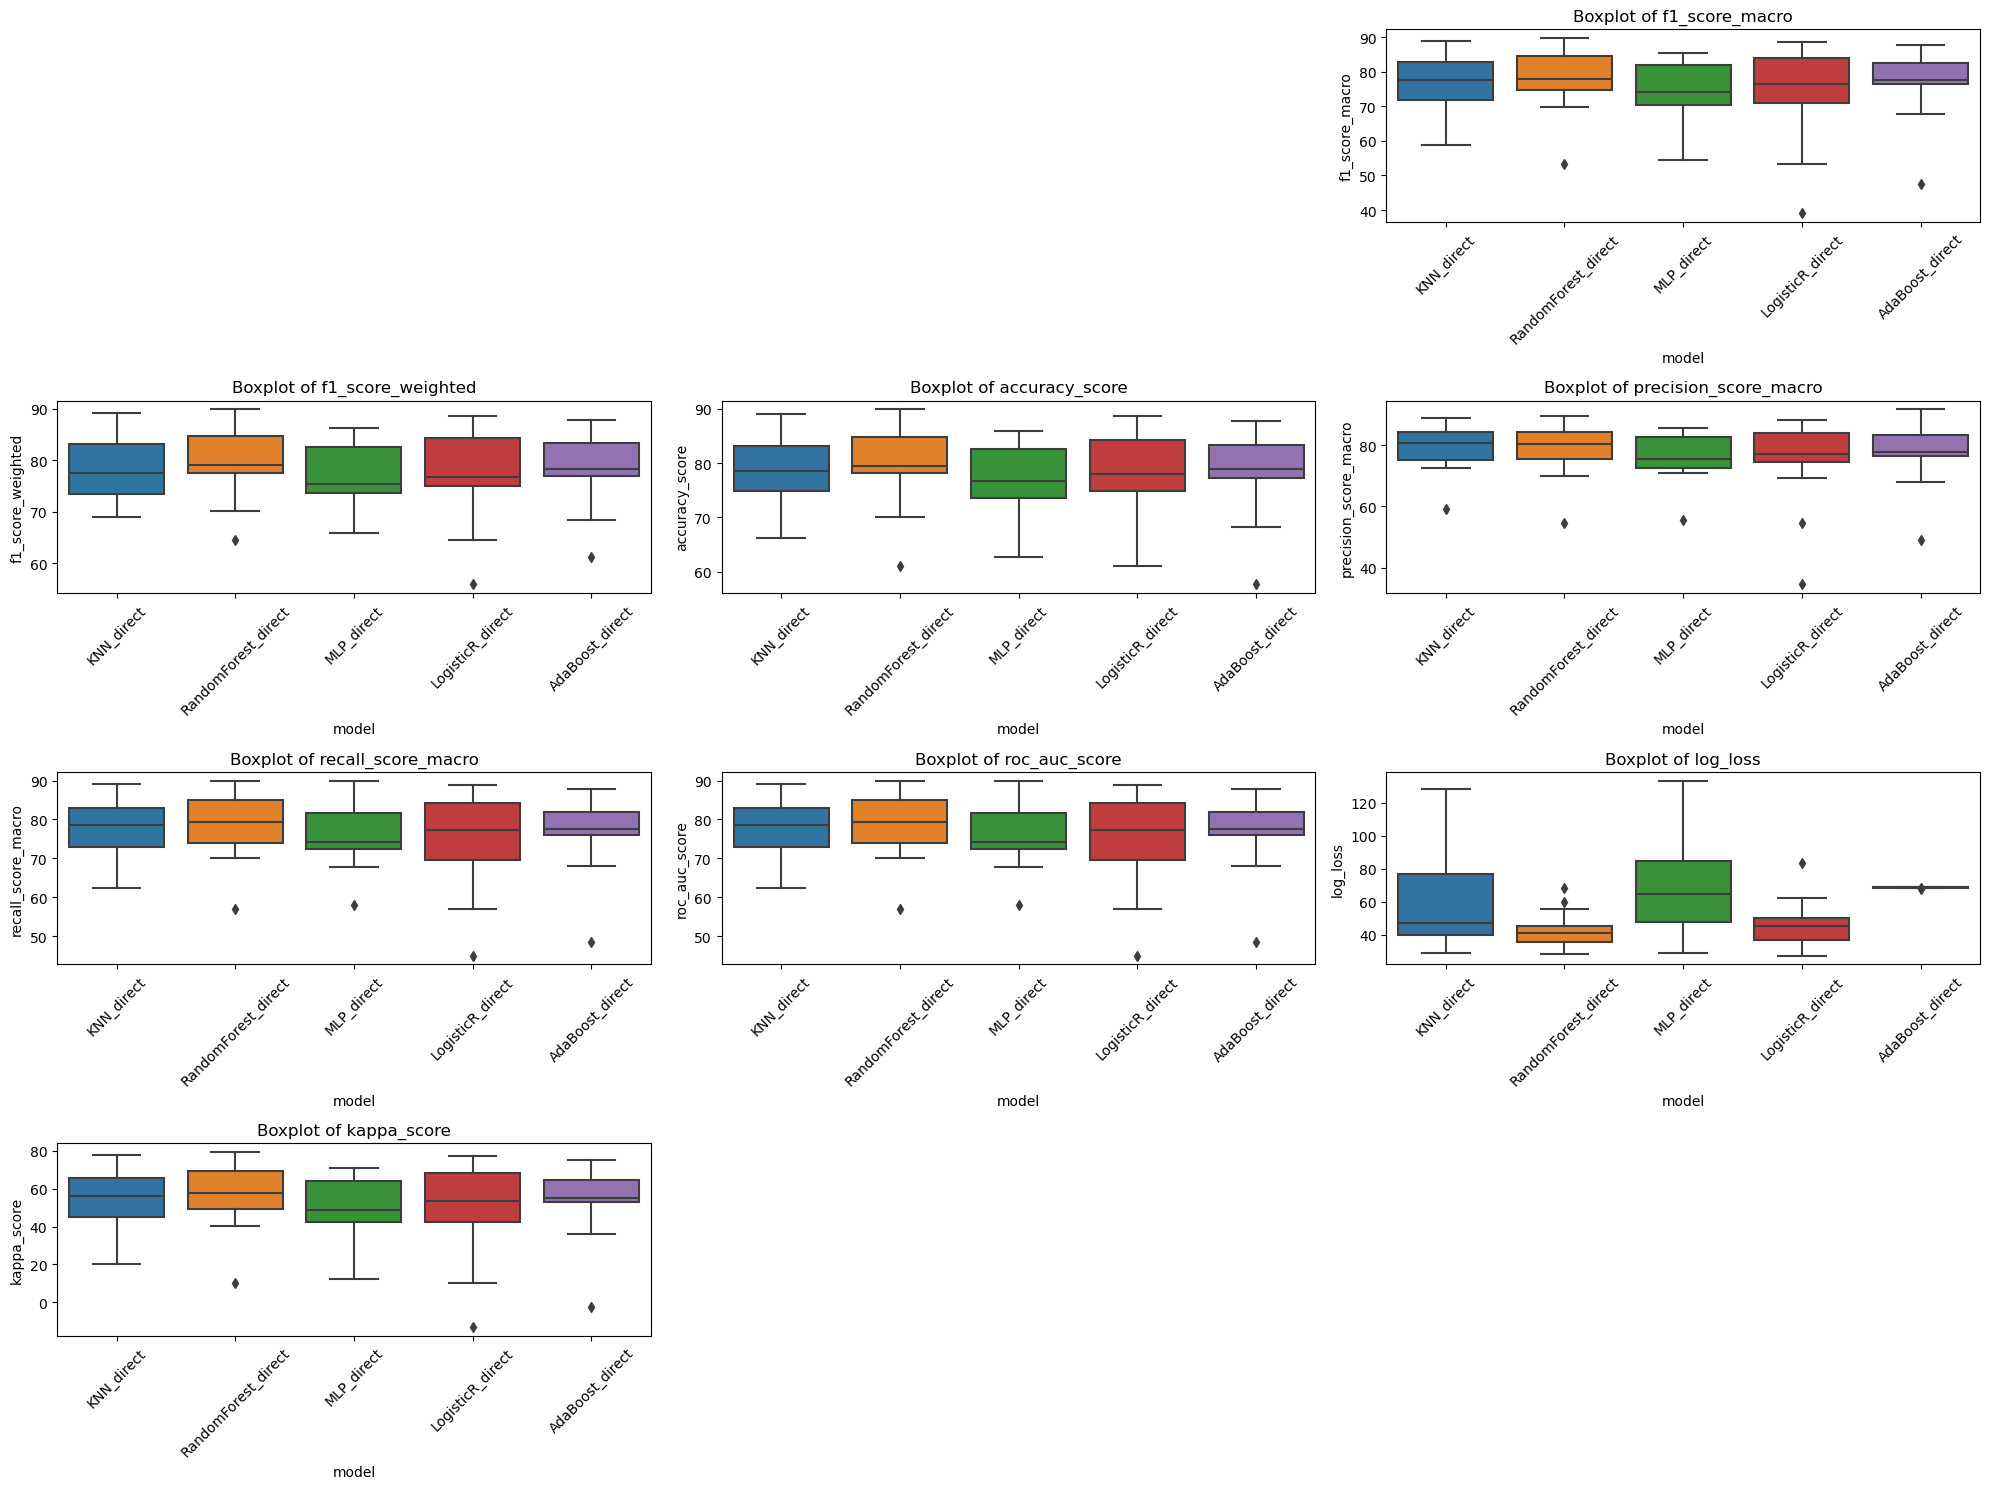

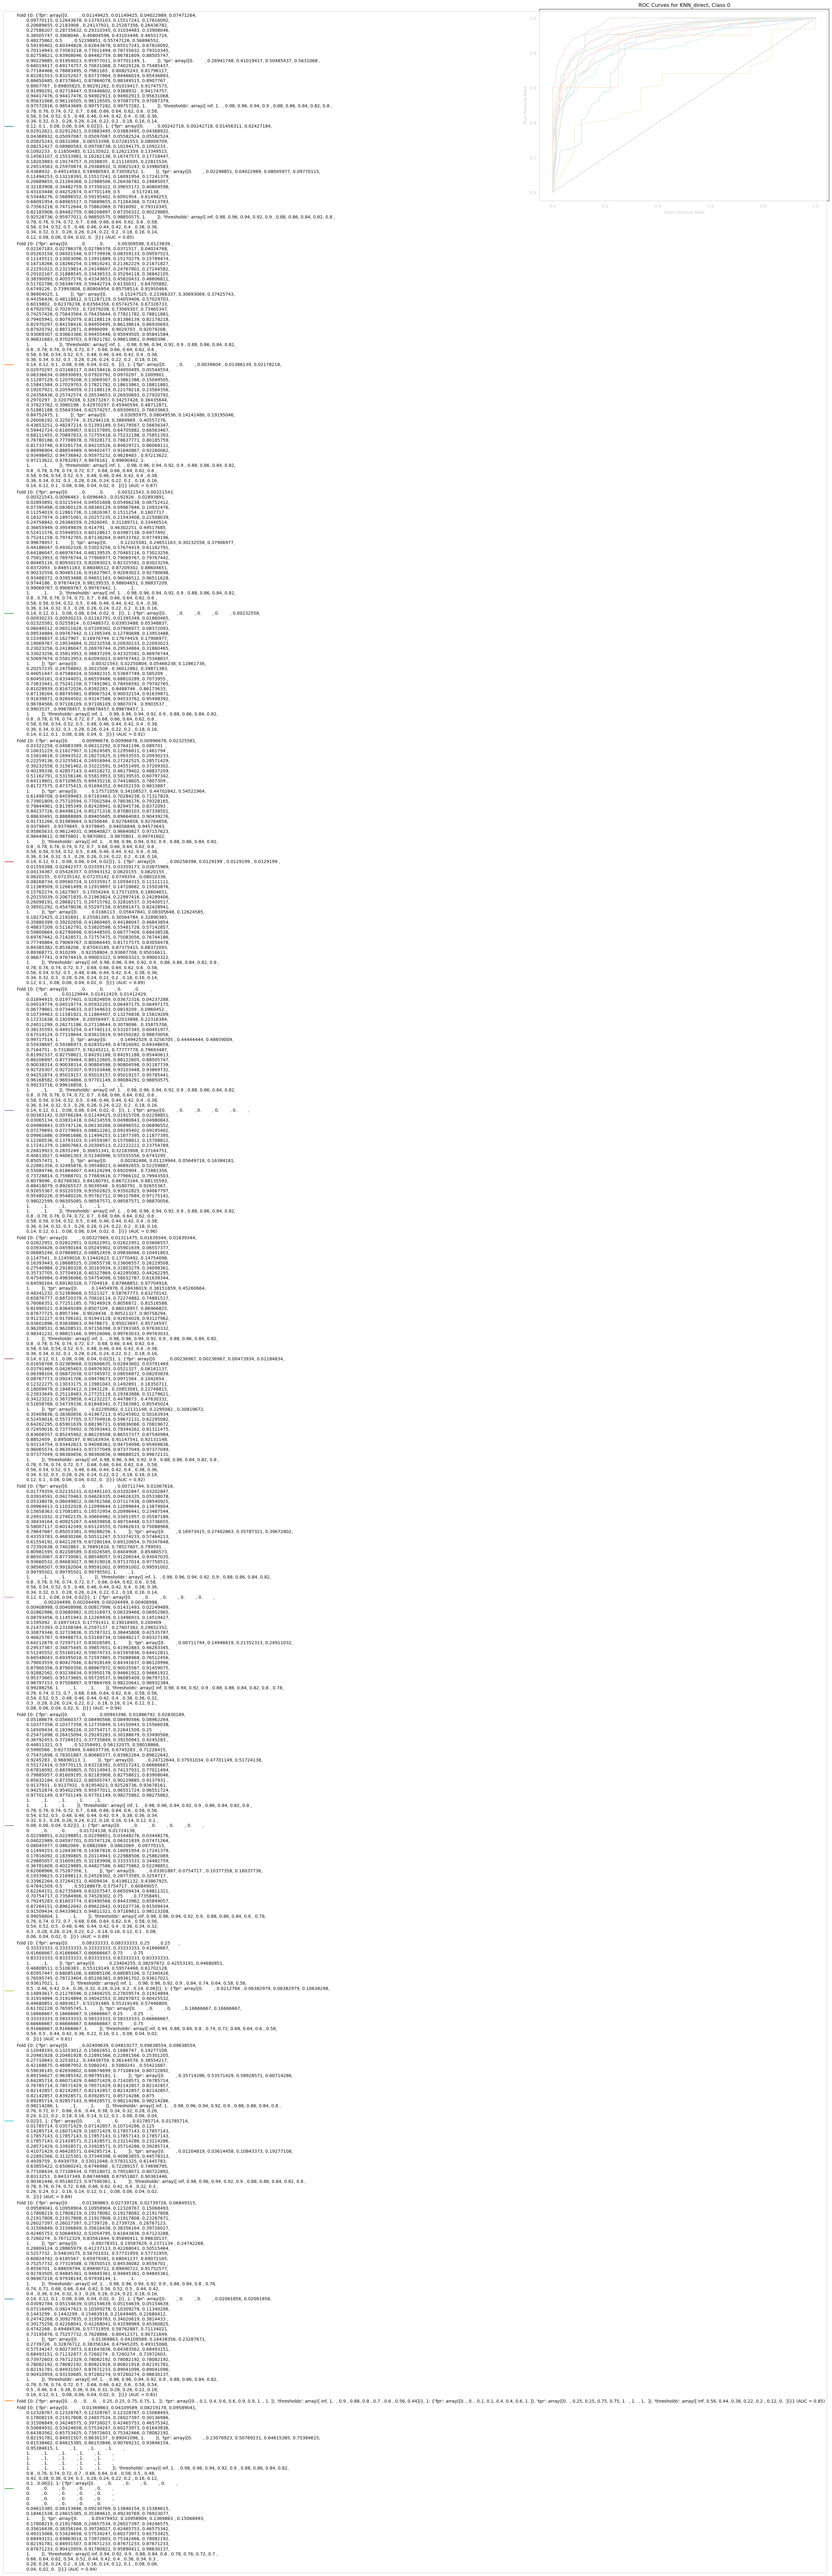

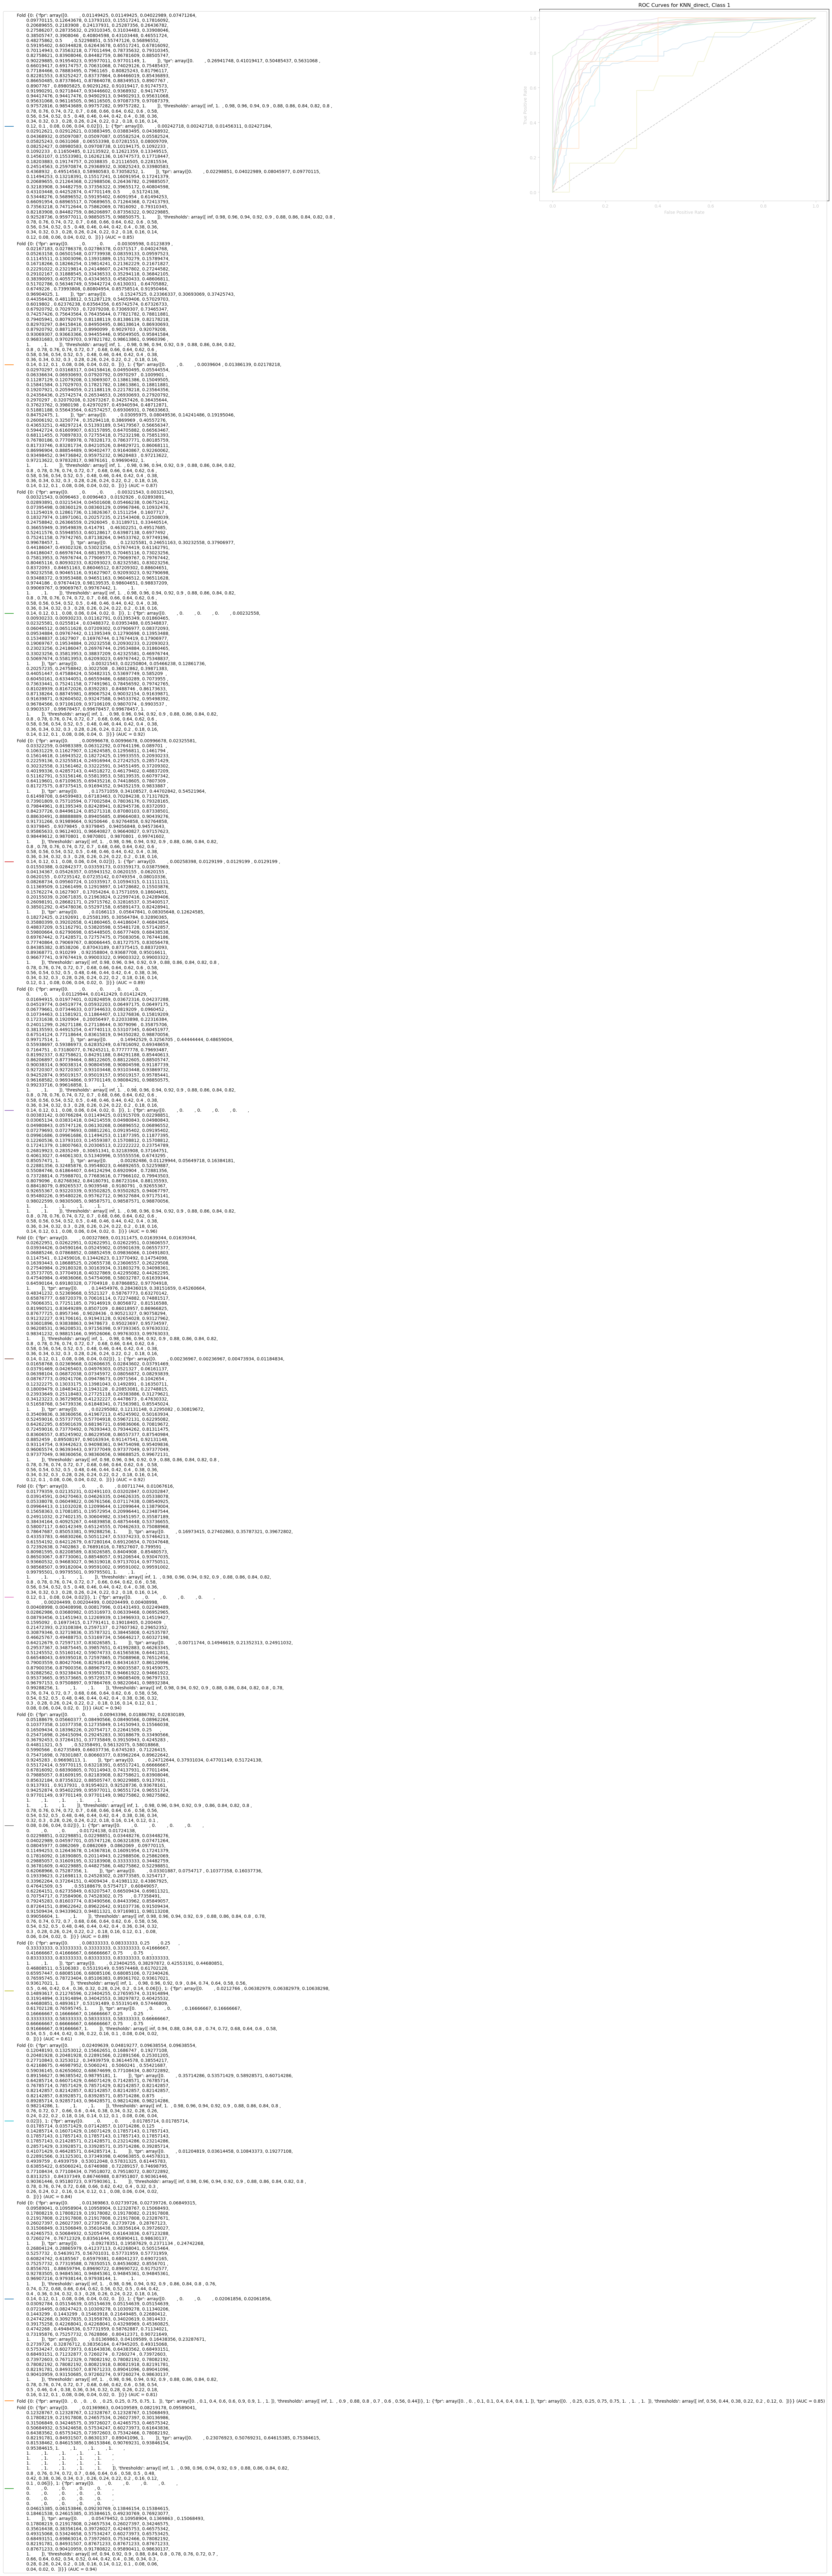

KeyboardInterrupt: 

In [93]:

create_plots(data)

In [14]:
param_path = "../parameter/config_data_local.yml"
pipeline_param = load_yaml(param_path)

In [15]:
pipeline_param["generate_results"]

{'quantitative': {'f1_score': True,
  'weighted_F1_score': True,
  'roc_curves': True,
  'conf_matrix': True},
 'qualitative': {'maps': True, 'dates': ['15/05/2024', '31/01/2023']}}

In [31]:
param_path = "../parameter/config_pipeline.yml"
pipeline_param = load_yaml(param_path)

match pipeline_param["type"]:
    case "local":
        local_param_path = "../parameter/config_data_local.yml"
        data_param = load_yaml(local_param_path)
    case "global":
        global_param_path = "pipeline/parameter/config_data_global.yml"
        data_param = load_yaml(global_param_path)
    case _:
        f"no such type : {pipeline_param["type"]}"

try:
    data_path = "../data/dataset/dataset_AD_08200821_14Mas3Top3Phy_W15_corrected.h5"
    out_dir = pipeline_param["out_dir"]
    seed = pipeline_param["seed"]
    BANDS_MAX = pipeline_param["BANDS_MAX"]
except KeyError as e:
    print("KeyError: %s undefine" % e)

start_line = 0

# y_nagler = Nagler_estimation(data_path)
# print(y_nagler)

dtst_ld = Dataset_loader(
    data_path,
    shuffle=False,
)
dtst_ld.infos

KeyError: 'out_dir' undefine


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data/dataset/dataset_AD_08200821_14Mas3Top3Phy_W15_corrected.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
dtst_ld.infos[(dtst_ld.infos['tmin'] > 0) & (dtst_ld.infos['hsnow'] > 40)]

date           massif aquisition aquisition2  elevation  slope  \
5632    2021-06-11       BELLEDONNE        ASC         ASC     2400.0   45.0   
5639    2021-06-11       BELLEDONNE        ASC         ASC     2400.0   45.0   
5640    2021-06-11       BELLEDONNE        ASC         ASC     2400.0   45.0   
5648    2021-06-11       BELLEDONNE        ASC         ASC     2400.0   45.0   
5650    2021-06-11       BELLEDONNE        ASC         ASC     2400.0   45.0   
...            ...              ...        ...         ...        ...    ...   
1283710 2021-05-29  GRANDES-ROUSSES        DSC         DSC     2400.0   45.0   
1283719 2021-05-29  GRANDES-ROUSSES        DSC         DSC     2400.0   45.0   
1283738 2021-05-29  GRANDES-ROUSSES        DSC         DSC     2400.0   45.0   
1283759 2021-05-29  GRANDES-ROUSSES        DSC         DSC     2400.0   45.0   
1283833 2021-05-29  GRANDES-ROUSSES        DSC         DSC     2400.0   45.0   

         orientation  tmin       tel      hsnow  
5632             0.0  0.01  1.764194  45.176708  
5639            45.0  0.01  2.185814  59.180344  
5640             0.0  0.01  1.764194  45.176708  
5648             0.0  0.01  1.764194  45.176708  
5650             0.0  0.01  1.764194  45.176708  
...              ...   ...       ...        ...  
1283710         45.0  0.01  1.595417  47.645008  
1283719         45.0  0.01  1.595417  47.645008  
1283738         45.0  0.01  1.595417  47.645008  
1283759         45.0  0.01  1.595417  47.645008  
1283833         45.0  0.01  1.595417  47.645008  

[14901 rows x 10 columns]

In [5]:
# Example of request
rq1 = "(date.dt.month == 3 and date.dt.day== 1) and ((elevation > 1000) and (elevation < 1750))"

x, y = dtst_ld.request_data(rq1)

Request: (date.dt.month == 3 and date.dt.day== 1) and ((elevation > 1000) and (elevation < 1750)) with 5861 samples
(5861, 15, 15, 9)


In [16]:
x.shape[1:]

(15, 15, 9)

In [6]:
np.unique(y["metadata"][:,1])

array(['ARAVIS', 'BAUGES', 'BEAUFORTAIN', 'BELLEDONNE', 'CHARTEUSE',
       'GRANDES-ROUSSES', 'HTE-MAURIE', 'HTE-TARENT', 'MAURIENNE',
       'MONT-BLANC', 'THABOR', 'VANOISE', 'VERCORS'], dtype='<U15')

In [7]:
fold =  fold_management(methode = "combinationFold", shuffle=False, random_state=42, train_aprox_size=0.80)
lab_man = label_management(methode = "crocus") 
targets = lab_man.transform(y)

In [8]:
np.unique(targets, return_counts=True)

(array([0, 1]), array([3355, 2506]))

In [9]:
fold.split(x, y)

<generator object combination_method at 0x7c51db461cc0>

In [10]:
for i, (train_index, test_index) in enumerate(fold.split(x, y)):

    print(f"Fold {i}:")

    print(f"    Train: index={train_index}")
    print(f"    Test:  index={test_index}")
    print(f"    distribution class train: {np.unique(targets[train_index], return_counts=True)}")
    print(f"    distribution class test: {np.unique(targets[test_index], return_counts=True)}")
    print(f"    train size: {len(train_index)/(len(train_index)+len(test_index))}")
    print(f"    massices in train {np.unique(y["metadata"][train_index,1])}")
    print(f"    massices in test {np.unique(y["metadata"][test_index,1])}")

Fold 0:
    Train: index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

In [28]:
for massive in (np.unique(y['metadata'][:, 1], return_counts=True)):
    print(massive[0] )

ARAVIS
828


In [11]:
massives_count = {}

for index, name in enumerate(y['metadata'][:, 1]):
    if name not in massives_count:
        massives_count[name] = {'count': 0, 'indices': []}
    massives_count[name]['count'] += 1
    
massives_count

{'BELLEDONNE': {'count': 615, 'indices': []},
 'MONT-BLANC': {'count': 386, 'indices': []},
 'HTE-MAURIE': {'count': 138, 'indices': []},
 'BAUGES': {'count': 770, 'indices': []},
 'HTE-TARENT': {'count': 139, 'indices': []},
 'MAURIENNE': {'count': 586, 'indices': []},
 'VANOISE': {'count': 688, 'indices': []},
 'BEAUFORTAIN': {'count': 741, 'indices': []},
 'VERCORS': {'count': 170, 'indices': []},
 'GRANDES-ROUSSES': {'count': 59, 'indices': []},
 'ARAVIS': {'count': 828, 'indices': []},
 'CHARTEUSE': {'count': 727, 'indices': []},
 'THABOR': {'count': 14, 'indices': []}}

In [12]:
massives_count = {}

for index, name in enumerate(y['metadata'][:, 1]):
    if name not in massives_count:
        massives_count[name] = {'count': 0, 'indices': []}
    massives_count[name]['count'] += 1
    massives_count[name]['indices'].append(index)

massives_count

{'BELLEDONNE': {'count': 615,
  'indices': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   13